# train STIMP imputation function
We construct 9 datasets with different missing rate from 0.1 to 0.9.
```bash
for i in {0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9}
do
  python imputation/train_stimp.py --missing_ratio $i --area MEXICO
done
```

# training other baselines

```bash
for i in {0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9}
do
  python imputation/train_{}.py --missing_ratio $i --area MEXICO
done
```


# Run STIMP

In [1]:
import torch
import numpy as np 
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
print(sys.path)
from dataset.dataset_imputation import PRE8dDataset

['/home/mafzhang/code/STIMP/tutorials/..', '/home/mafzhang/miniconda3/envs/torch/lib/python39.zip', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/mafzhang/.local/lib/python3.9/site-packages', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages']


In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='MEXICO', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

**Fig 4a**

In [3]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("../log/imputation/MEXICO/STIMP/best_0.1.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("../data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [4]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
is_sea = np.load("../data/MEXICO/is_sea.npy")
H, W = is_sea.shape
model = DINEOF(10, [H, W, config.in_len])
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,H,W)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(198720, 3)
(198720,)


2025-01-23 10:20:09.211 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 170: 0.0016650264305946123, 9.920004288855363e-06


PearsonRResult(statistic=0.9924378259638824, pvalue=0.0)
PearsonRResult(statistic=0.0871341048421029, pvalue=0.005829483113814726)


(array([-2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4')])

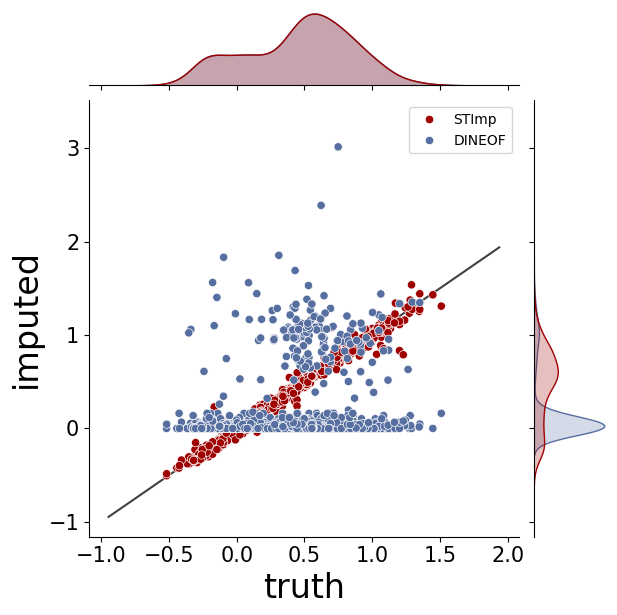

In [5]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:1000]
imputed_dineof = imputed_dineof[:1000]
truth = truth[:1000]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STImp' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color, marginal_kws={'common_norm':False})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_dineof))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [6]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("../log/imputation/MEXICO/STIMP/best_0.5.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [7]:
from einops import rearrange
from model.dineof import DINEOF
is_sea = np.load("../data/MEXICO/is_sea.npy")
H, W = is_sea.shape
model = DINEOF(10, [H, W, config.in_len])
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,H,W)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(198720, 3)
(198720,)


2025-01-23 10:21:19.016 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 151: 0.0019110377304846463, 9.985047880742021e-06


PearsonRResult(statistic=0.9813363024069675, pvalue=0.0)
PearsonRResult(statistic=0.13475333718646604, pvalue=1.9074356453049183e-05)


(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

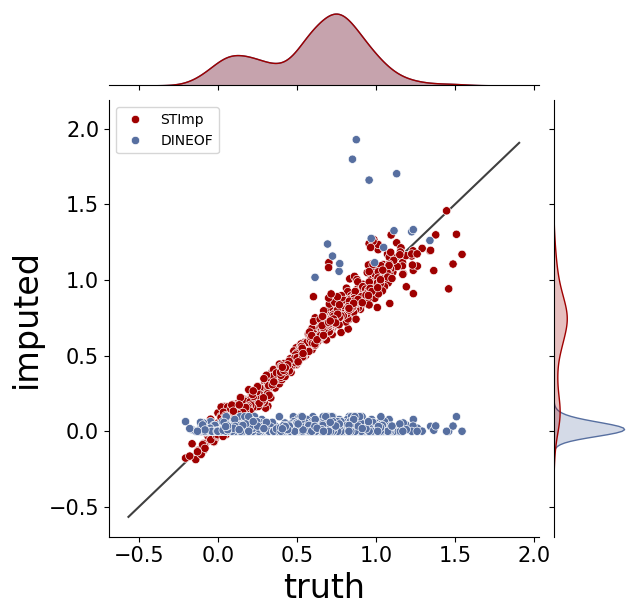

In [8]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:1000]
imputed_dineof = imputed_dineof[:1000]
truth = truth[:1000]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STImp' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color, marginal_kws={'common_norm':False})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_dineof))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [9]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("../log/imputation/MEXICO/STIMP/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [10]:
from einops import rearrange
from model.dineof import DINEOF
is_sea = np.load("../data/MEXICO/is_sea.npy")
H, W = is_sea.shape
model = DINEOF(10, [H, W, config.in_len])
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,H,W)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(198720, 3)
(198720,)


2025-01-23 10:22:12.074 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 101: 0.0006626415157842046, 9.897725756354025e-06


PearsonRResult(statistic=0.9386239435764459, pvalue=0.0)
PearsonRResult(statistic=0.12282619190257206, pvalue=9.860457960015649e-05)


(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

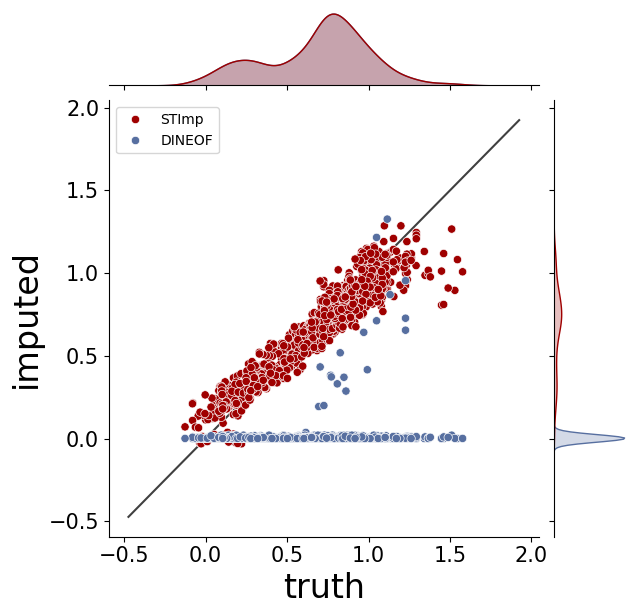

In [11]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:1000]
imputed_dineof = imputed_dineof[:1000]
truth = truth[:1000]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STImp' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color, marginal_kws={'common_norm':False})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_dineof))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)